NOTE !!

Due to a lack of time, I have not been able to retrain the networks with autoaugment, the data used in the notebook is taken from folder "without autoaugment".

## Imports

In [1]:
INIT_PATH = "."
DOWNLOAD_DATA = False

# To use google colab processing uncomment following lines

#INIT_PATH = "MyDrive/inference_and_learning"
#from google.colab import drive
#MOUNT_PATH = "/content/drive"
#drive.mount(MOUNT_PATH)
#INIT_PATH = MOUNT_PATH + "/" + INIT_PATH
#DOWNLOAD_DATA = True

# To train set to true, to use pretrained model set to false
RETRAIN = False
LOCAL_TRAIN = True # Only for Local Linear Model

# To avoid out of memory error, adjust 
NUM_THREADS = 3

In [2]:
import os.path,sys
sys.path.append(INIT_PATH)

import networks as nnets
import importlib
importlib.reload(nnets)

import pandas as pd, torch, torchvision,matplotlib, matplotlib.pyplot as plt, numpy as np, random
from typing import Tuple, List, Dict, Union

from time import sleep
import json
from IPython.display import display, HTML
torch.set_default_dtype(torch.float16)

In [3]:
DATA_PATH = "." # Path to data folder
if (DOWNLOAD_DATA):
    torchvision.datasets.CIFAR10(root=DATA_PATH + '/data', download=True)
    torchvision.datasets.CIFAR100(root=DATA_PATH + '/data', download=True)
    torchvision.datasets.SVHN(root=DATA_PATH +'/data', download=True)

    torchvision.datasets.CIFAR10(root=DATA_PATH +'/data', download=True,train = False)
    torchvision.datasets.CIFAR100(root=DATA_PATH +'/data', download=True ,train = False) 
    torchvision.datasets.SVHN(root=DATA_PATH +'/data', download=True, split = "test")


## Training
The following code trains network and save result in files

Two steps are realized :
1. Optimization of the hyperparameters from the optim file
2. Training of the network from the train file
    

In [4]:
trainer = nnets.ThreadedTrainer(
    num_threads= NUM_THREADS,
    DATA_PATH=DATA_PATH,
    SAVE_RESULT_PATH= INIT_PATH + "/files/results.json",
    SAVE_NETWORK_PATH=INIT_PATH + "/networks_saved/",
    SAVE_NON_ZERO_PATH = INIT_PATH + "/files/non_zero.json",
    saving_step= 20
)

Trainer ready


### Training

You may use this script to train networks from the /files/train.json file

In [5]:
train_net = json.load(open(INIT_PATH+"/files/train.json"))
for key,item in train_net.items():
    if item["model"]["name"] in ["S-LOCAL","D-LOCAL"] and not LOCAL_TRAIN:
        continue
    if not RETRAIN and os.path.isfile(INIT_PATH+"/networks_saved/"+key+".pth"):
        continue
    trainer.add(key,nnets.Network(item),item["model"]["name"] == "S-FC" and key.split("_")[1] == "B-lasso(B=50)")

In [7]:
trainer.progress()

RESULTS :
         Model     |   Optimizer   |    Dataset    ||    optimization_parameters   ||    accuracy   
    ---------------|---------------|---------------||------------------------------||---------------

TASKS REMAINING :
    1. S-CONV_SGD_CIFAR-10                    10. 3-FC_SGD_CIFAR-10
    2. S-CONV_SGD_CIFAR-100                   11. 3-FC_SGD_CIFAR-100
    3. S-CONV_SGD_SVHN                        12. 3-FC_SGD_SVHN
    4. S-LOCAL_SGD_CIFAR-10                   13. S-FC_B-lasso(B=0)_CIFAR-10
    5. S-LOCAL_SGD_CIFAR-100                  14. S-FC_B-lasso(B=0)_CIFAR-100
    6. S-LOCAL_SGD_SVHN                       15. S-FC_B-lasso(B=0)_SVHN
    7. S-FC_SGD_CIFAR-10                      16. S-FC_B-lasso(B=10)_CIFAR-10
    8. S-FC_SGD_CIFAR-100                     17. S-FC_B-lasso(B=10)_CIFAR-100
    9. S-FC_SGD_SVHN                          18. S-FC_B-lasso(B=10)_SVHN

GENERAL INFO :
    Accuracy updated every 20 epochs
    GPU available: 0.42GB out of 8.35GB
    GPU max usag

### Destroy trainer

In [ ]:
del trainer

## Reproducing the paper


### Table 2

In [7]:
table2 = pd.read_csv(INIT_PATH+"/files_paper/table2.csv")
results = json.load(open(INIT_PATH+"/files/results.json"))

for dataset in ["CIFAR-10","CIFAR-100","SVHN"]:
    for line in range(len(table2)):
        iline = table2.iloc[line].to_dict()
        if iline[dataset] == "nan": continue
        ID = iline["Model"] + "_" + iline["Training_Method"] + "_" + dataset
        if ID in results:
            table2.loc[line,dataset] = "{:.2f}%".format(results[ID])
display(HTML(table2.fillna("").to_html(notebook=True)))

,Model,Training_Method,CIFAR-10,CIFAR-100,SVHN
0,S-CONV,SGD,62.37%,30.46%,85.57%
1,S-LOCAL,SGD,57.91%,29.32%,0%
2,MLP (Neyshabur et al. 2019),SGD,58.1%,,84.3%
3,MLP (Mukkamala and Hein 2017),ADAM_RMS,72.2%,39.3%,
4,MLP (Mocanu et al. 2018),SET,74.84%,,
5,MLP (Urban et al. 2017),deep_conv_teacher,74.3%,,
6,MLP (Lin et al. 2016),ZAE,78.62%,,
7,3-FC,SGD,59.44%,30.80%,44.29%
8,S-FC,SGD,59.80%,32.12%,85.64%
9,S-FC,B-lasso(B=0),59.03%,31.11%,87.26%


### figure 3
We can reuse result saved while training table 2

In [54]:
#region getting the data :
data_non_zero_un = json.load(open(INIT_PATH+"/files/non_zero.json"))
data_non_zero = {}
order = ["CIFAR-10","CIFAR-100","SVHN"]
for o in order:
    for key,item in data_non_zero_un.items():
        if o in key:
            data_non_zero[key] = item    

train_net = json.load(open(INIT_PATH+"/files/train.json"))

# transfer the data to 3 numpy array, one for each graph
graph1: Dict[str,Union[np.ndarray,int]] = {k:np.array(v["conv_like"]) for k,v in data_non_zero.items()}
graph2: Dict[str,Union[np.ndarray,int]] = {k:np.array(v["FC1"]) for k,v in data_non_zero.items()}
graph3: Dict[str,Union[np.ndarray,int]] = {k:np.array(v["FC2"]) for k,v in data_non_zero.items()}
#We also need the number of parameters of corresponding S-LOCAL and S-CONV
s_conv = nnets.n_cl.get_model(nnets.Network(train_net["S-CONV_SGD_CIFAR-10"]).model,32,10)
s_conv100 = nnets.n_cl.get_model(nnets.Network(train_net["S-CONV_SGD_CIFAR-100"]).model,32,100)
s_local = nnets.n_cl.get_model(nnets.Network(train_net["S-LOCAL_SGD_CIFAR-10"]).model,32,10)
graph1.update({
    "param_S-CONV" : nnets.n_utils.count_parameters(s_conv,"conv_like"),
    "param_S-LOCAL" : nnets.n_utils.count_parameters(s_local,"conv_like")
})
graph2["param_ "] = nnets.n_utils.count_parameters(s_conv,"FC.FC1")
graph3.update({
    "param_10" : nnets.n_utils.count_parameters(s_conv,"FC.FC2"),
    "param_100" : nnets.n_utils.count_parameters(s_conv100,"FC.FC2")
})
#endregion


Text(0.5, 0.98, 'Number of non zero weights for each model')

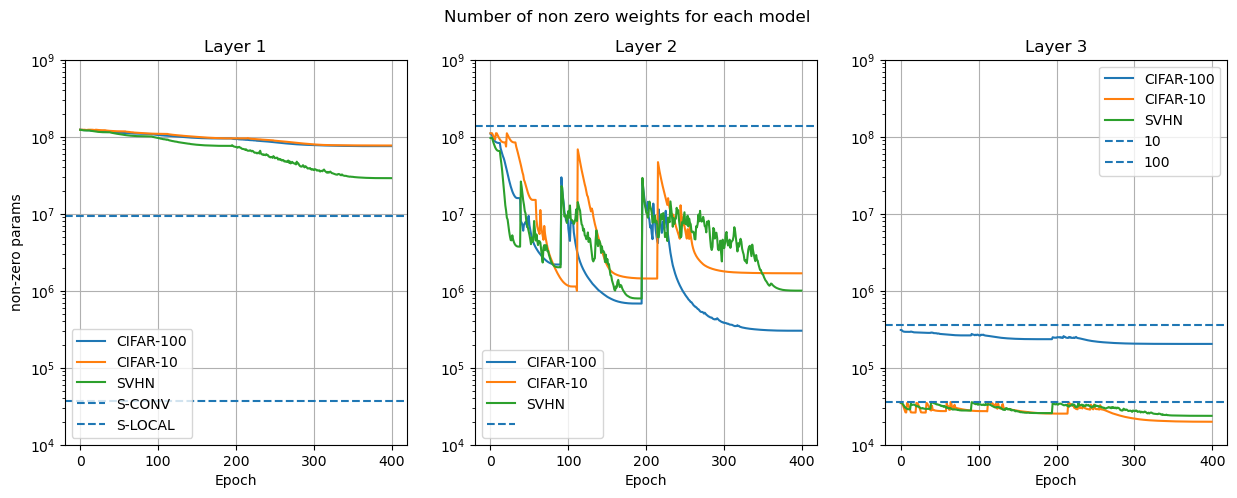

In [55]:

fig,axs = plt.subplots(1,3,figsize=(15,5))
for i,graph in enumerate([graph1,graph2,graph3]):
    for key,values in graph.items():
        if "param" not in key:
            axs[i].plot(values,label=key.split("_")[2])
        else :
            axs[i].axhline(int(values),ls="--",label=key.split("_")[1],color="red")
    axs[i].set_title("Layer {}".format(i+1))
    axs[i].set_xlabel("Epoch")
    axs[i].set_yscale("log")
    axs[i].set_ylim(1e4,1e9)

    
axs[0].set_ylabel("non-zero params")
for ax in axs:    
    ax.legend()
    ax.grid()
    
fig.suptitle("Number of non zero weights for each model")

### figure 4

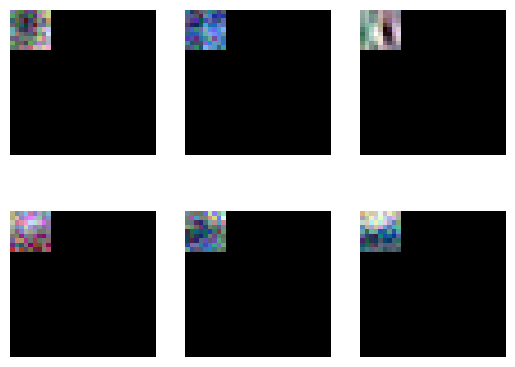

In [107]:
# Fetch the train file
train_net = json.load(open(INIT_PATH+"/files/train.json"))

# Create the figure
fig = plt.figure()
subfigures = fig.subfigures(3, 3)

# First let's add titles :
datasets = ["CIFAR-10", "CIFAR-100", "SVHN"]
for dataset, subfigure in zip(datasets, subfigures[0]):
    subfigure.set_title(dataset)
# Since first two rows are S-FC we can group them together
optimizer = ["SGD", "B-lasso(B=50)"]
for i,op in enumerate(optimizer):
    subfigures[i][0].set_ylabel(op)
    for dataset, subfigure in zip(datasets, subfigures[i]):
        net_name = "S-FC_"+op+"_"+dataset
        # Fetch the model
        model = nnets.n_cl.get_model(nnets.Network(train_net[net_name]).model,32,10)
        model.load_state_dict(torch.load(INIT_PATH+f"/networks_saved/{net_name}.pth"))
        # Get the weights
        w:torch.Tensor = model.conv_like.FC.weight.data
        w = w.view(w.shape[0],3,32,32).permute(0,2,3,1).detach()
        w = w[w.to(torch.bool).sum(dim=(1,2,3))>20]
        # Plot the weights
        axs = subfigure.subplots(3, 2)
        for ax in axs.flat:
            ax.set(xlabel='Epochs', ylabel='Accuracy')
            img = w[random.randint(0,w.shape[0])]
            img = img - img.min()
            img = img / img.max()
            ax.imshow(img)
            ax.axis('off')
# We can do something similar for the last row
subfigures[2][0].set_ylabel("S-CONV")
for dataset, subfigure in zip(datasets, subfigures[2]):
    net_name = "S-CONV_SGD_"+dataset
    # Fetch the model
    model = nnets.n_cl.get_model(nnets.Network(train_net[net_name]).model,32,10)
    model.load_state_dict(torch.load(INIT_PATH+f"/networks_saved/{net_name}.pth"))
    # Get the weights
    w:torch.Tensor = model.conv_like.conv.weight.data
    w = w.view(w.shape[0],3,9,9).permute(0,2,3,1).detach()
    # Plot the weights
    axs = subfigure.subplots(3, 2)
    for ax in axs.flat:
        ax.set(xlabel='Epochs', ylabel='Accuracy')
        img = w[random.randint(0,w.shape[0])]
        img = img - img.min()
        img = img / img.max()
        img_real = np.zeros((32,32,3))
        img_real[0:9,0:9,:] = img
        ax.imshow(img_real)
        ax.axis("off")
        
plt.show()